In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline

from plotly.offline import iplot
from plotly.graph_objs import Scatter

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

%matplotlib inline

In [2]:
#https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm
app_train = pd.read_csv('app_train.csv')
app_test = pd.read_csv('app_test.csv')

app_train.drop(app_train[app_train['CODE_GENDER'] == 'XNA'].index, axis = 0, inplace=True )

# We store the TARGET column in the variable train_labels
train_labels = app_train['TARGET']

#We align the training and test data, We keep that the columns present in the two dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307507, 75)
Testing Features shape:  (48744, 74)


In [3]:
data = pd.read_csv('data_final.csv')

In [43]:
#### prepare final Train X and Test X dataframes 
ignore_features = ['SK_ID_CURR', 'is_train', 'is_test']
relevant_features = [col for col in data.columns if col not in ignore_features]
trainX = data[data['is_train'] == 1][relevant_features]
testX = data[data['is_test'] == 1][relevant_features]

In [5]:
data.head()

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account
0,0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,1,0
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,1,0
2,2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,1,0
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,1,0
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,1,0


In [44]:
Y = train_labels
len(Y)

307507

In [45]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(trainX, Y, test_size=0.3, random_state=42)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ('reduce_dim', 'passthrough'),
    ('classify', LinearSVC(dual=False, max_iter=10000))
])

N_FEATURES_OPTIONS = [25, 50, 100, 150, 200]
param_grid = [
   
    {
        'reduce_dim': [SelectKBest()],
        'reduce_dim__k': N_FEATURES_OPTIONS
    }
]
#reducer_labels = ['KBest(chi2)']

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid)
#X, y = load_digits(return_X_y=True)
grid.fit(x_train, y_train)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
print(mean_scores)

[0.91924424 0.91924424 0.9192396  0.9192303  0.91922101]


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
skb = SelectKBest(f_classif,k=50)

x_new = skb.fit_transform(x_train, y_train)
x_val_new = skb.transform(x_val)
x_test_final=skb.transform(testX)

100%|██████████| 5/5 [01:09<00:00, 13.92s/it]


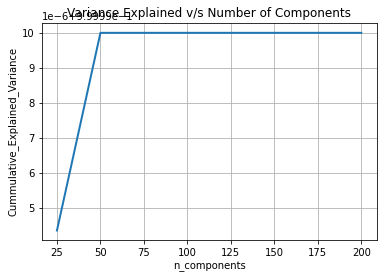

In [14]:
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
n_components = [25, 50 ,100 , 150 ,200 ]
variance_explained = []
for i in tqdm(n_components):
    svd = TruncatedSVD(n_components= i)
    svd.fit_transform(x_train, y_train)
    variance_explained.append(svd.explained_variance_ratio_.sum())
plt.grid()
plt.xlabel("n_components")
plt.ylabel("Cummulative_Explained_Variance")
plt.title("Variance Explained v/s Number of Components")
plt.plot(n_components, variance_explained,lw=2)
plt.show()

In [15]:
svd = TruncatedSVD(50)
svd.fit(x_train, y_train)
x_new1 = svd.fit_transform(x_train, y_train)
x_val_new1 = svd.transform(x_val)
#x_test_final=svd.transform(testX)
print("Train matrix shape after applying TruncatedSVD:", x_new1.shape)
print("Test matrix shape after applying TruncatedSVD:", x_val_new1.shape)

Train matrix shape after applying TruncatedSVD: (215254, 50)
Test matrix shape after applying TruncatedSVD: (92253, 50)


In [70]:
# Import necessary modules
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
# Import EarlyStopping
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
import sklearn.neighbors as nb
import sklearn.neighbors as  KNeighborsClassifier
from sklearn import linear_model
from sklearn.neighbors.nearest_centroid import NearestCentroid
import sklearn.model_selection as ms
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import  recall_score, precision_score, accuracy_score
from sklearn.linear_model import RidgeClassifier, Lasso,LogisticRegression
from mlxtend.classifier import StackingClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn import metrics, model_selection
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

<h3> Logistic Regression </h3>

<h4> Hyperparameter tuning Logistic Regression with select K best features</h4>

In [53]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'C':[(10**i)*x for i in range(-4, 1) for x in [1,3,5,10]]}

model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', random_state=42, max_iter=500, n_jobs=-1)
clf = RandomizedSearchCV(model, parameters, cv=5, scoring='f1', return_train_score=True, n_jobs=-1)
clf.fit(x_new, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'C': 0.5}
Best score: 0.18914190370999234


<h4>Training Logistic Regression with best hyperparameters </h4>

In [10]:
score = {}

**************************************************
Train AUC: 0.618
val AUC: 0.620
**************************************************
Train F1 score: 0.188
val F1 score: 0.188


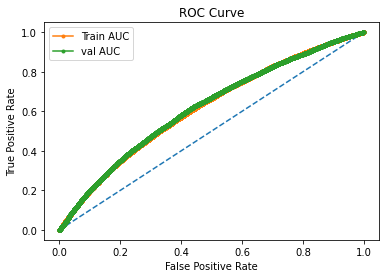

In [55]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score 
model = LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1)
model.fit(x_new, y_train)
y_probs_train = model.predict_proba(x_new)
y_probs_val = model.predict_proba(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and F1 score
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['Logistic Regression'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

<h4> Train Confusion Matrix </h4>

Confusion matrix:
 [[122246  75561]
 [  7808   9639]]


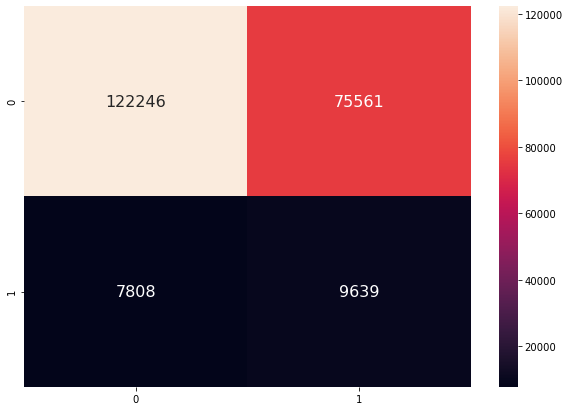

In [56]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Validation Confusion Matrix </h4>

Confusion matrix:
 [[52277 32598]
 [ 3233  4145]]


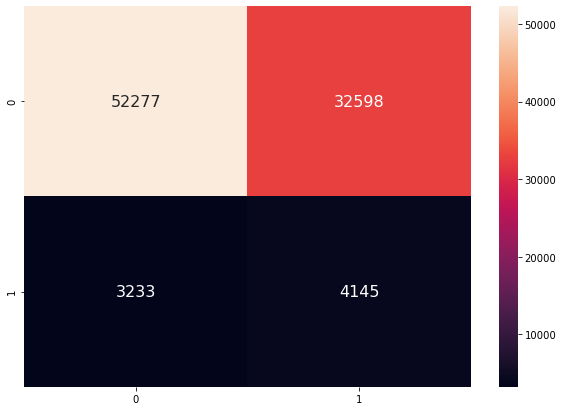

In [57]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Logistic Regression with all features

In [58]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'C':[(10**i)*x for i in range(-4, 1) for x in [1,3,5,10]]}

model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', random_state=42, max_iter=500, n_jobs=-1)
clf = RandomizedSearchCV(model, parameters, cv=5, scoring='f1', return_train_score=True, n_jobs=-1)
clf.fit(x_train, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'C': 0.00030000000000000003}
Best score: 0.20050034254313517


**************************************************
Train AUC: 0.634
val AUC: 0.636
**************************************************
Train F1 score: 0.196
val F1 score: 0.193


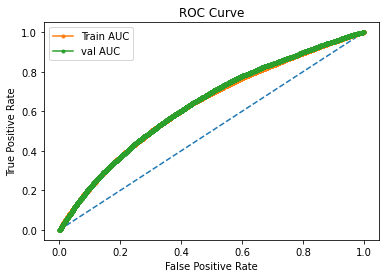

In [60]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score 
model = LogisticRegression(C=0.01, class_weight='balanced', n_jobs=-1)
model.fit(x_train, y_train)
y_probs_train = model.predict_proba(x_train)
y_probs_val = model.predict_proba(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and F1 score
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['Logistic Regression'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

<h3> Random Forest </h3>

<h4> Hyperparameter tuning Random Forest </h4>

In [61]:
params = {'n_estimators':[75, 100, 250, 500], 'max_depth':[3, 5, 10, 15]}
model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_new, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'n_estimators': 500, 'max_depth': 10}
Best score: 0.27241594319038215


<h4> Training random forest with best hyperparameters </h4>

**************************************************
Train AUC: 0.821
val AUC: 0.741
**************************************************
Train F1 score: 0.331
val F1 score: 0.273


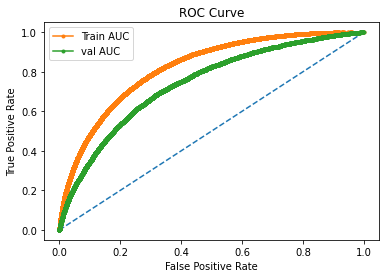

In [62]:
model = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight='balanced', n_jobs=-1)
model.fit(x_new, y_train)
y_probs_train = model.predict_proba(x_new)
y_probs_val = model.predict_proba(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['Random Forest'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


<h4> Train Confusion Matrix </h4>

Confusion matrix:
 [[153850  43957]
 [  5291  12156]]


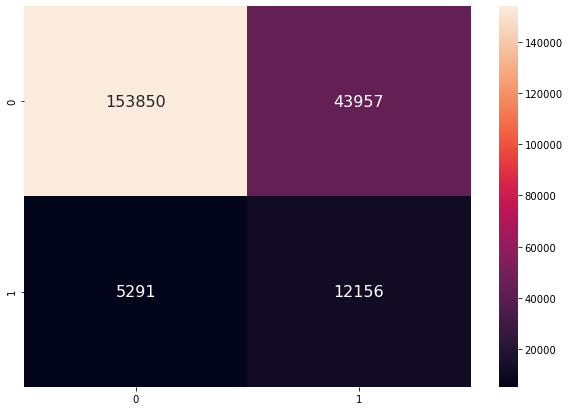

In [63]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Validation Confusion Matrix </h4>

Confusion matrix:
 [[65222 19653]
 [ 3110  4268]]


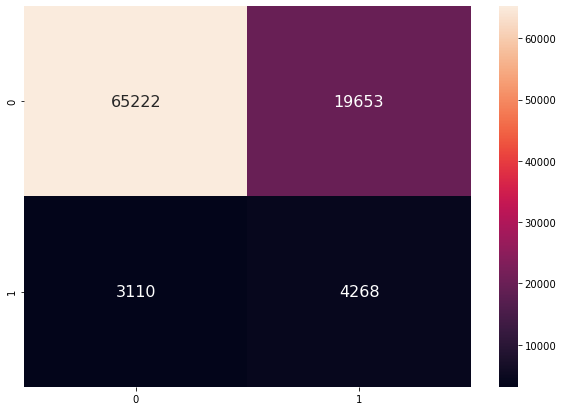

In [64]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Random Forest with all features

In [65]:
params = {'n_estimators':[75, 100, 250, 500], 'max_depth':[3, 5, 10, 15]}
model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_train, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'n_estimators': 500, 'max_depth': 10}
Best score: 0.2761055610518571


**************************************************
Train AUC: 0.832
val AUC: 0.742
**************************************************
Train F1 score: 0.345
val F1 score: 0.276


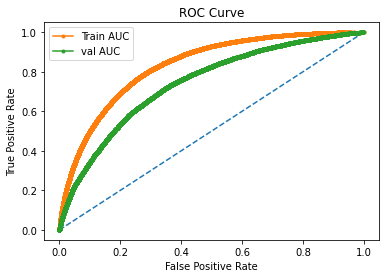

In [66]:
model = RandomForestClassifier(n_estimators=500, max_depth=10, class_weight='balanced', n_jobs=-1)
model.fit(x_train, y_train)
y_probs_train = model.predict_proba(x_train)
y_probs_val = model.predict_proba(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['Random Forest'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


<h3> SVM </h3>

<h4> Hyperparameter tuning  SVM </h4>

In [67]:
from sklearn.linear_model import SGDClassifier
params = {'alpha': [10**i for i in range(-4, 5)]}

model = SGDClassifier(loss='hinge', penalty='l2',max_iter=1000,class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_new, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'alpha': 0.01}
Best score: 0.15916498942999105


<h4> Training SVM with best hyperparameters </h4>

**************************************************
Train AUC: 0.531
val AUC: 0.527
**************************************************
Train F1 score: 0.157
val F1 score: 0.153


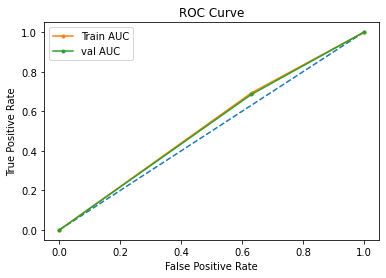

In [68]:
model = SGDClassifier(alpha=10, class_weight='balanced', n_jobs=-1)
model.fit(x_new, y_train)
y_probs_train = model.predict(x_new)
y_probs_val = model.predict(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['SVM'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


<h4> Train Confusion Matrix </h4>

Confusion matrix:
 [[ 72902 124905]
 [  5345  12102]]


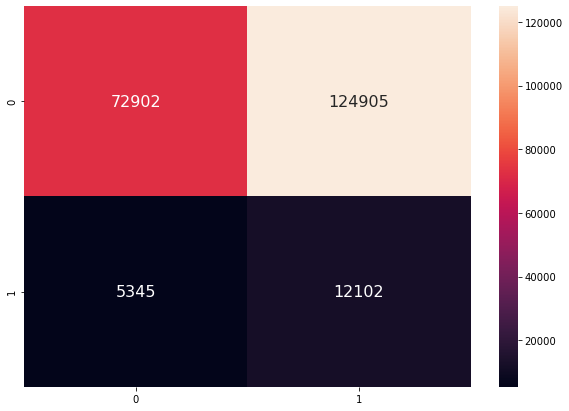

In [69]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Validation Confusion Matrix </h4>

Confusion matrix:
 [[31311 53564]
 [ 2319  5059]]


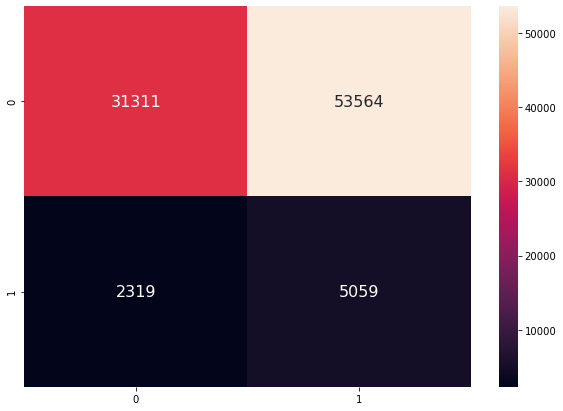

In [70]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## SVM with all Feature

In [71]:
from sklearn.linear_model import SGDClassifier
params = {'alpha': [10**i for i in range(-4, 5)]}

model = SGDClassifier(loss='hinge', penalty='l2',max_iter=1000,class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_train, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'alpha': 0.1}
Best score: 0.15133211897746202


**************************************************
Train AUC: 0.577
val AUC: 0.580
**************************************************
Train F1 score: 0.181
val F1 score: 0.180


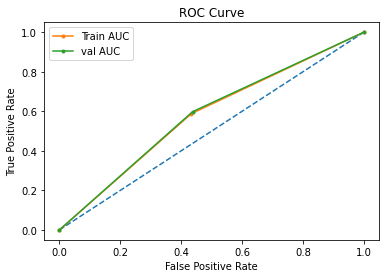

In [75]:
model = SGDClassifier(alpha=10, class_weight='balanced', n_jobs=-1)
model.fit(x_train, y_train)
y_probs_train = model.predict(x_train)
y_probs_val = model.predict(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['SVM'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


<h3> XGBoost </h3>

<h4> Hyperparameter tuning XGBClassifier </h4>

In [76]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth': [3, 5, 10], 'n_estimators': [10, 100, 500]}

model = XGBClassifier(class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_new, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'n_estimators': 500, 'max_depth': 5}
Best score: 0.08293063278559096


<h4> Training XGBClassifier with best hyperparameters </h4>

**************************************************
Train AUC: 0.825
val AUC: 0.753
**************************************************
Train F1 score: 0.111
val F1 score: 0.074


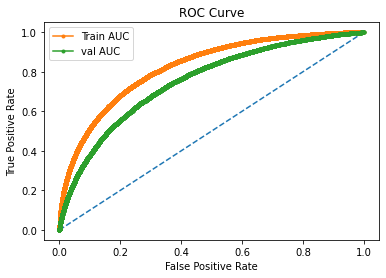

In [82]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
model = XGBClassifier(max_depth=3, n_estimators=500 ,class_weight='balanced', n_jobs=-1)
model.fit(x_new, y_train)
y_probs_train = model.predict_proba(x_new)
y_probs_val = model.predict_proba(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['XGBoost'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

<h4> Train Confusion Matrix </h4>

Confusion matrix:
 [[197662    145]
 [ 13801   3646]]


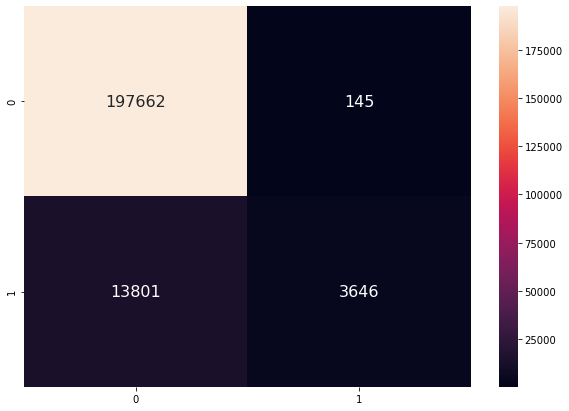

In [78]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Validation Confusion Matrix </h4>

Confusion matrix:
 [[84354   521]
 [ 7022   356]]


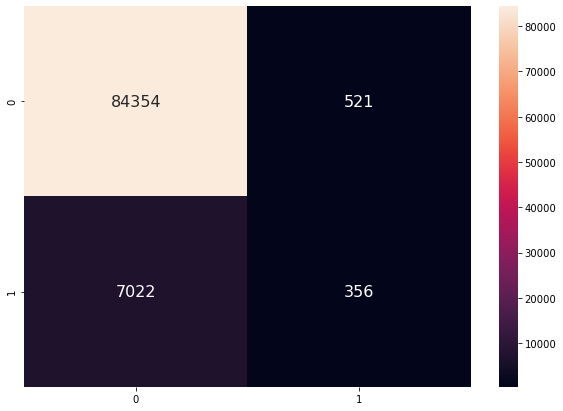

In [79]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## XGBOOST with all features

In [80]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth': [3, 5, 10], 'n_estimators': [10, 100, 500]}

model = XGBClassifier(class_weight='balanced', n_jobs=-1)
clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_train, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

Best parameters:  {'n_estimators': 500, 'max_depth': 5}
Best score: 0.11350541155893837


**************************************************
Train AUC: 0.846
val AUC: 0.767
**************************************************
Train F1 score: 0.156
val F1 score: 0.093


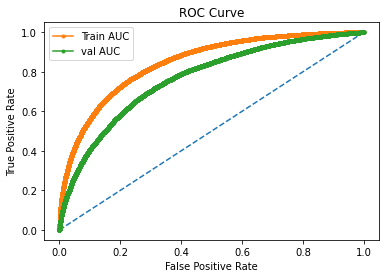

In [84]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
model = XGBClassifier(max_depth=3, n_estimators=500 ,class_weight='balanced', n_jobs=-1)
model.fit(x_train, y_train)
y_probs_train = model.predict_proba(x_train)
y_probs_val = model.predict_proba(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['XGBoost'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

## Stacking Classifier

### Hyperparameter tuning meta-classifier (Logistic Regression)

In [0]:
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

model_1 = LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1)
model_1.fit(x_new, y_train)
clf_1 = CalibratedClassifierCV(model_1, method='sigmoid')

model_2 = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced', n_jobs=-1)
model_2.fit(x_new, y_train)
clf_2 = CalibratedClassifierCV(model_2, method='sigmoid')

model_3 = SGDClassifier(alpha=10, class_weight='balanced', n_jobs=-1)
model_3.fit(x_new, y_train)
clf_3 = CalibratedClassifierCV(model_3, method='sigmoid')

model_4 = XGBClassifier(n_estimators= 500, max_depth= 3, class_weight='balanced', n_jobs=-1)
model_4.fit(x_new, y_train)
clf_4 = CalibratedClassifierCV(model_4, method='sigmoid')

C = [0.001,0.01,0.1,1,10]
roc = 0
best_C = 0
for i in C:
    log_reg = LogisticRegression(C=i, n_jobs=-1)
    model = StackingClassifier(classifiers=[clf_1, clf_2, clf_4], meta_classifier=log_reg, use_probas=True)
    model.fit(x_new, y_train)
    model_roc = f1_score(y_val, model.predict(x_val_new))
    if roc < model_roc:
        roc = model_roc
        best_C = i

**************************************************
Train AUC: 0.761
val AUC: 0.742
**************************************************
Train F1 score: 0.143
val F1 score: 0.119


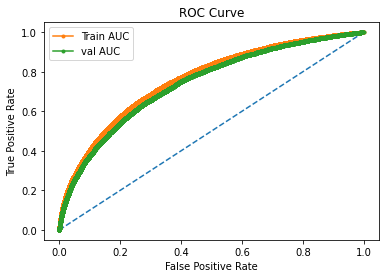

In [0]:
from mlxtend.classifier import StackingClassifier

log_reg = LogisticRegression(C=0.001, n_jobs=-1)
stack_clf = StackingClassifier(classifiers=[clf_1, clf_2, clf_4], meta_classifier=log_reg, use_probas=True)
model.fit(x_new, y_train)
y_probs_train = model.predict_proba(x_new)
y_probs_val = model.predict_proba(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['Stacking Classifier'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the stack_clf
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

<h4> Train Confusion Matrix </h4>

Confusion matrix:
 [[196316   1491]
 [  4890  12557]]


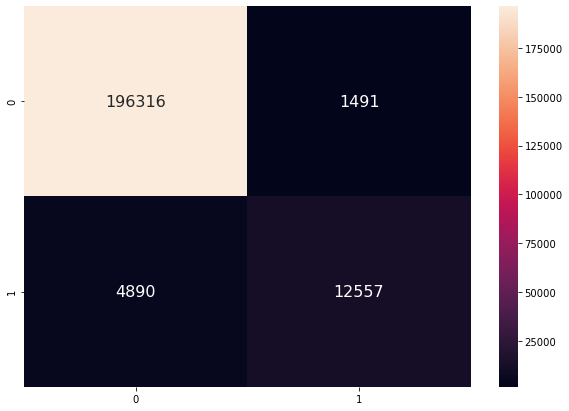

In [30]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Test Confusion Matrix </h4>

Confusion matrix:
 [[82646  2229]
 [ 6561   817]]


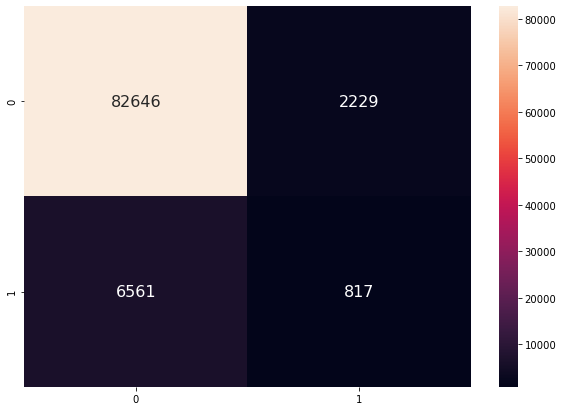

In [31]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Stacking classifier with all the feature

In [0]:
from sklearn.calibration import CalibratedClassifierCV
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

model_1 = LogisticRegression(C=0.5, class_weight='balanced', n_jobs=-1)
model_1.fit(x_train, y_train)
clf_1 = CalibratedClassifierCV(model_1, method='sigmoid')

model_2 = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced', n_jobs=-1)
model_2.fit(x_train, y_train)
clf_2 = CalibratedClassifierCV(model_2, method='sigmoid')

model_3 = SGDClassifier(alpha=10, class_weight='balanced', n_jobs=-1)
model_3.fit(x_train, y_train)
clf_3 = CalibratedClassifierCV(model_3, method='sigmoid')

model_4 = XGBClassifier(n_estimators= 500, max_depth= 3, class_weight='balanced', n_jobs=-1)
model_4.fit(x_train, y_train)
clf_4 = CalibratedClassifierCV(model_4, method='sigmoid')

C = [0.001,0.01,0.1]
roc = 0
best_C = 0
for i in C:
    log_reg = LogisticRegression(C=i, n_jobs=-1)
    model = StackingClassifier(classifiers=[clf_1, clf_2, clf_4], meta_classifier=log_reg, use_probas=True)
    model.fit(x_train, y_train)
    model_roc = f1_score(y_val, model.predict(x_val))
    if roc < model_roc:
        roc = model_roc
        best_C = i

**************************************************
Train AUC: 0.783
val AUC: 0.757
**************************************************
Train F1 score: 0.179
val F1 score: 0.149


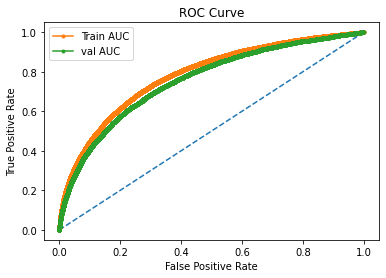

In [19]:
from mlxtend.classifier import StackingClassifier

log_reg = LogisticRegression(C=0.001, n_jobs=-1)
stack_clf = StackingClassifier(classifiers=[clf_1, clf_2, clf_4], meta_classifier=log_reg, use_probas=True)
model.fit(x_train, y_train)
y_probs_train = model.predict_proba(x_train)
y_probs_val = model.predict_proba(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['Stacking Classifier'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the stack_clf
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

## Voting Classifier

**************************************************
Train AUC: 0.740
val AUC: 0.725
**************************************************
Train F1 score: 0.010
val score: 0.010


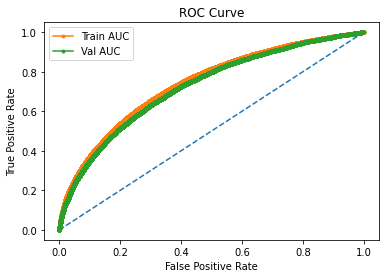

In [20]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('log_reg', clf_1), ('rf', model_2), ('stack', stack_clf), ('xgb', model_4), ('log_reg_1', model_1)], voting='soft')
model.fit(x_new, y_train)
y_probs_train = model.predict_proba(x_new)
y_probs_val = model.predict_proba(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)
# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val score: %.3f' % val_f1)

score['Voting Classifier'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='Val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

<h4> Train Confusion Matrix </h4>

Confusion matrix:
 [[197807      0]
 [ 16971    476]]


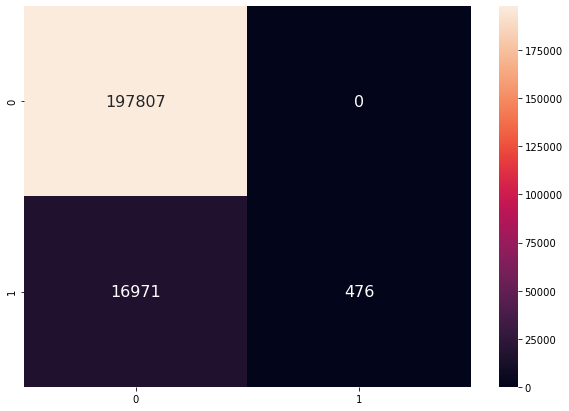

In [34]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Validation Confusion Matrix </h4>

Confusion matrix:
 [[84865    10]
 [ 7365    13]]


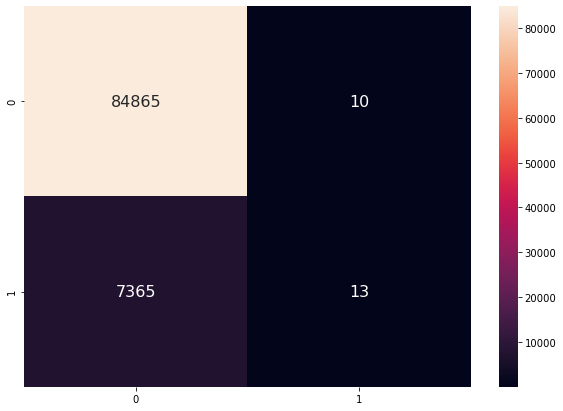

In [35]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Voting Classfier with all the feature

In [ ]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Validation Confusion Matrix </h4>

from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**************************************************
Train AUC: 0.759
val AUC: 0.736
**************************************************
Train F1 score: 0.020
val score: 0.016


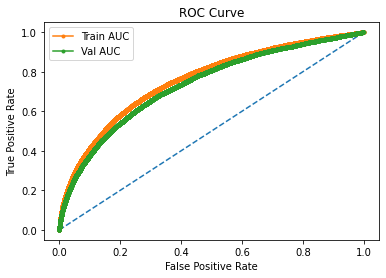

In [21]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('log_reg', clf_1), ('rf', model_2), ('stack', stack_clf), ('xgb', model_4), ('log_reg_1', model_1)], voting='soft')
model.fit(x_train, y_train)
y_probs_train = model.predict_proba(x_train)
y_probs_val = model.predict_proba(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)
# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val score: %.3f' % val_f1)

score['Voting Classifier'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='Val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# CATBOOST CLASSIFIER

In [13]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
params={ 'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
       }

model= CatBoostClassifier(iterations=700,
                             custom_metric='AUC:hints=skip_train~false',
                             loss_function='Logloss',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100,verbose=None)

clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_new, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

0:	learn: 0.5888120	total: 403ms	remaining: 4m 41s
75:	learn: 0.2306207	total: 22.5s	remaining: 3m 4s
150:	learn: 0.2142592	total: 44.5s	remaining: 2m 41s
225:	learn: 0.2004276	total: 1m 7s	remaining: 2m 20s
300:	learn: 0.1872045	total: 1m 29s	remaining: 1m 58s
375:	learn: 0.1758966	total: 1m 51s	remaining: 1m 35s
450:	learn: 0.1648015	total: 2m 13s	remaining: 1m 13s
525:	learn: 0.1552271	total: 2m 34s	remaining: 51.3s
600:	learn: 0.1452851	total: 2m 57s	remaining: 29.2s
675:	learn: 0.1364620	total: 3m 20s	remaining: 7.12s
699:	learn: 0.1337324	total: 3m 27s	remaining: 0us
Best parameters:  {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'depth': 10}
Best score: 0.05153715563174911


0:	learn: 0.5901214	total: 57.8ms	remaining: 57.8s
100:	learn: 0.2455674	total: 4.46s	remaining: 39.7s
200:	learn: 0.2404814	total: 8.73s	remaining: 34.7s
300:	learn: 0.2362461	total: 13.2s	remaining: 30.7s
400:	learn: 0.2326141	total: 18.2s	remaining: 27.2s
500:	learn: 0.2291177	total: 23.7s	remaining: 23.6s
600:	learn: 0.2258677	total: 29.2s	remaining: 19.4s
700:	learn: 0.2226816	total: 35.6s	remaining: 15.2s
800:	learn: 0.2195475	total: 41.7s	remaining: 10.4s
900:	learn: 0.2166128	total: 47.9s	remaining: 5.26s
999:	learn: 0.2137774	total: 53.7s	remaining: 0us
**************************************************
Train AUC: 0.838
val AUC: 0.751
**************************************************
Train F1 score: 0.176
val F1 score: 0.050


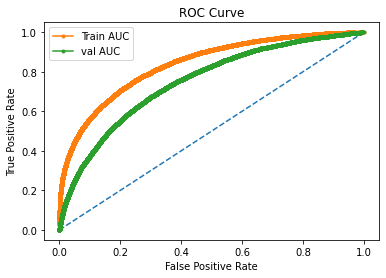

In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
model = CatBoostClassifier(max_depth=6, learning_rate=0.1,verbose=None,metric_period=100)
model.fit(x_new, y_train)
y_probs_train = model.predict_proba(x_new)
y_probs_val = model.predict_proba(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['XGBoost'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

<h4> Train Confusion Matrix </h4>

Confusion matrix:
 [[197767     40]
 [ 16446   1001]]


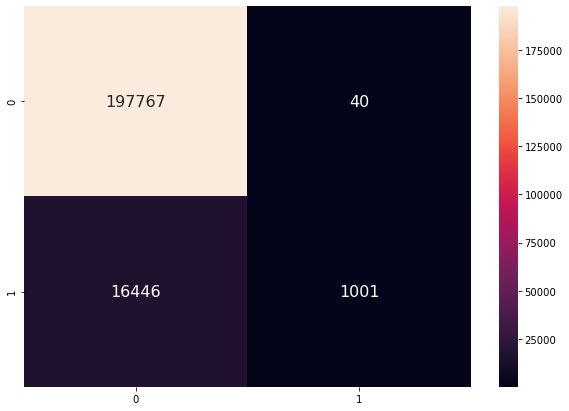

In [38]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Test Confusion Matrix </h4>

Confusion matrix:
 [[84791    84]
 [ 7323    55]]


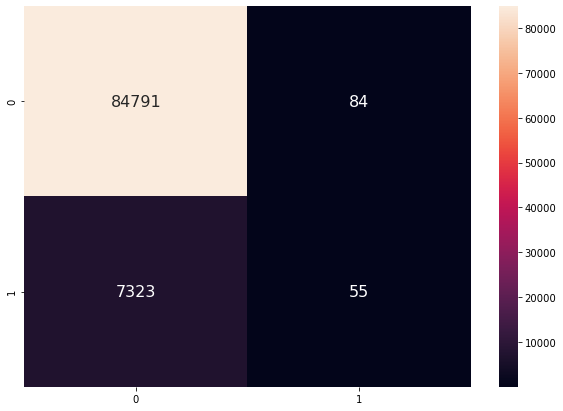

In [40]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [ ]:

from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_predicted_train)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

<h4> Test Confusion Matrix </h4>

from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_predicted_val)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Catboost Classfier with all the feature

In [15]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
params={ 'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
       }

model= CatBoostClassifier(iterations=700,
                             custom_metric='AUC:hints=skip_train~false',
                             loss_function='Logloss',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100,verbose=None)

clf = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring='f1', random_state=42, n_jobs=-1, return_train_score=True)
clf.fit(x_train, y_train)
print('Best parameters:  {}'.format(clf.best_params_))
print('Best score: {}'.format(clf.best_score_))

0:	learn: 0.5906697	total: 119ms	remaining: 1m 23s
75:	learn: 0.2439282	total: 8.78s	remaining: 1m 12s
150:	learn: 0.2385384	total: 17s	remaining: 1m 1s
225:	learn: 0.2346067	total: 25.1s	remaining: 52.7s
300:	learn: 0.2312247	total: 33.6s	remaining: 44.6s
375:	learn: 0.2281222	total: 41.9s	remaining: 36.1s
450:	learn: 0.2251677	total: 50.6s	remaining: 28s
525:	learn: 0.2225067	total: 1m	remaining: 20.1s
600:	learn: 0.2199508	total: 1m 10s	remaining: 11.7s
675:	learn: 0.2173596	total: 1m 21s	remaining: 2.88s
699:	learn: 0.2165895	total: 1m 25s	remaining: 0us
Best parameters:  {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'depth': 6}
Best score: 0.06800614320189032


0:	learn: 0.5943537	total: 129ms	remaining: 2m 8s
100:	learn: 0.2419512	total: 14.5s	remaining: 2m 9s
200:	learn: 0.2356484	total: 27s	remaining: 1m 47s
300:	learn: 0.2309292	total: 38.1s	remaining: 1m 28s
400:	learn: 0.2265350	total: 49.1s	remaining: 1m 13s
500:	learn: 0.2224679	total: 1m	remaining: 59.9s
600:	learn: 0.2187832	total: 1m 10s	remaining: 47.1s
700:	learn: 0.2153011	total: 1m 21s	remaining: 34.8s
800:	learn: 0.2119182	total: 1m 32s	remaining: 22.9s
900:	learn: 0.2087374	total: 1m 43s	remaining: 11.3s
999:	learn: 0.2057726	total: 1m 53s	remaining: 0us
**************************************************
Train AUC: 0.856
val AUC: 0.771
**************************************************
Train F1 score: 0.211
val F1 score: 0.078


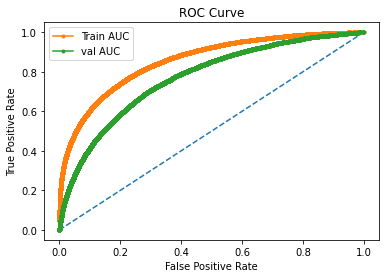

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
model = CatBoostClassifier(max_depth=6, learning_rate=0.1,metric_period=100)
model.fit(x_train, y_train)
y_probs_train = model.predict_proba(x_train)
y_probs_val = model.predict_proba(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)

score['XGBoost'] = [val_auc, val_f1]

# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

## LightGBM with selected features:

In [65]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
from sklearn.model_selection import RandomizedSearchCV

params =  {
    'max_depth': [3,5,7],
    'n_estimators': [75, 100, 150],
    'boosting_type':['gbdt','dart','goss'],
    'learning_rate':[0.001,0.05,0.1,1],
    'colsample_bytree': [0.7,0.8,1]
}

model = LGBMClassifier(num_leaves=31,n_estimators=100,objective='binary',
                       class_weight='balanced',n_jobs=-1,max_bin= 512,
                          subsample_for_bin= 200,
                          subsample= 0.7,
                          subsample_freq= 1,
                          reg_alpha= 20,
                          reg_lambda=20,
                          min_split_gain= 0.5,
                          min_child_weight= 1,
                          min_child_samples= 10,
                          scale_pos_weight= 1,
                          num_class = 1)
clf = RandomizedSearchCV(model, param_distributions=params, scoring='accuracy', return_train_score=True, n_jobs=-1, cv=5)
clf.fit(x_new, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, importance_type='split', learning_rate=1,
               max_bin=512, max_depth=5, min_child_samples=10,
               min_child_weight=1, min_split_gain=0.5, n_estimators=150,
               n_jobs=-1, num_class=1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=20, reg_lambda=20,
               scale_pos_weight=1, silent=True, subsample=0.7,
               subsample_for_bin=200, subsample_freq=1)
0.7685398487551085


**************************************************
Train AUC: 0.8206
val AUC:  0.7865
**************************************************
Train F1 score: 0.190
val F1 score: 0.104


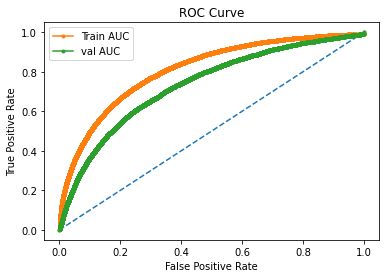

In [63]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
model = LGBMClassifier(boosting_type='dart', learning_rate=1,colsample_bytree=0.8,max_depth=5,n_estimators=75)
model.fit(x_new, y_train)
y_probs_train = model.predict_proba(x_new)
y_probs_val = model.predict_proba(x_val_new)
y_predicted_train = model.predict(x_new)
y_predicted_val = model.predict(x_val_new)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)


# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='val AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

Confusion matrix:
 [[142604  55267]
 [  5377  12006]]


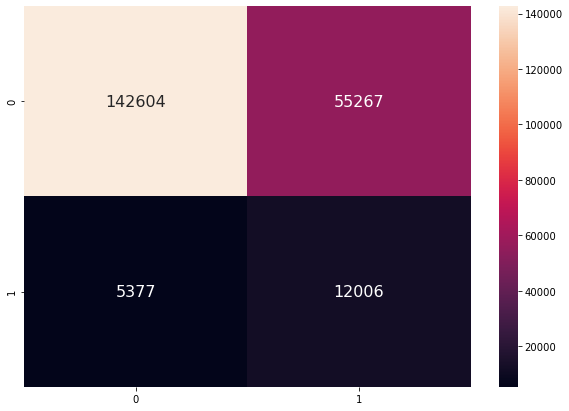

In [47]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_train, y_pred_prob)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Confusion matrix:
 [[60816 23995]
 [ 2589  4853]]


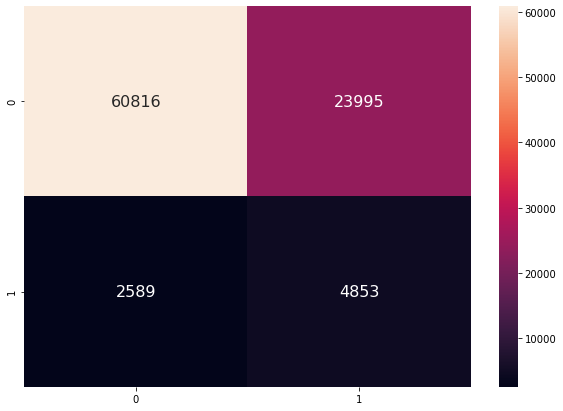

In [51]:
from sklearn.metrics import confusion_matrix

cma = confusion_matrix(y_val, y_pred_prob1)
print('Confusion matrix:\n', cma)
df_cm = pd.DataFrame(cma, range(2), columns=range(2))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## LGBM CLASSFIER with all the feature

In [58]:
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
from sklearn.model_selection import RandomizedSearchCV
params =  {
    'max_depth': [3,5,7],
    'n_estimators': [75, 100, 150],
    'boosting_type':['gbdt','dart','goss'],
    'learning_rate':[0.001,0.05,0.1,1],
    'colsample_bytree': [0.7,0.8,1]
}

model = LGBMClassifier(num_leaves=31,n_estimators=100,objective='binary',
                       class_weight='balanced',n_jobs=-1,max_bin= 512,
                          subsample_for_bin= 200,
                          subsample= 0.7,
                          subsample_freq= 1,
                          reg_alpha= 20,
                          reg_lambda=20,
                          min_split_gain= 0.5,
                          min_child_weight= 1,
                          min_child_samples= 10,
                          scale_pos_weight= 1,
                          num_class = 1)
clf = RandomizedSearchCV(model, param_distributions=params, scoring='accuracy', return_train_score=True, n_jobs=-1, cv=5)
clf.fit(x_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.7, importance_type='split', learning_rate=1,
               max_bin=512, max_depth=5, min_child_samples=10,
               min_child_weight=1, min_split_gain=0.5, n_estimators=150,
               n_jobs=-1, num_class=1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=20, reg_lambda=20,
               scale_pos_weight=1, silent=True, subsample=0.7,
               subsample_for_bin=200, subsample_freq=1)
0.7810398487481192


**************************************************
Train AUC: 0.8214
val AUC: 0.8002
**************************************************
Train F1 score: 0.076
val F1 score: 0.055


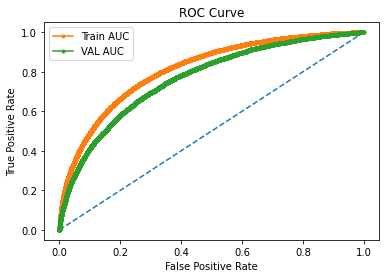

In [61]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1,colsample_bytree=0.8,max_depth=7,n_estimators=100)
model.fit(x_train, y_train)
y_probs_train = model.predict_proba(x_train)
y_probs_val = model.predict_proba(x_val)
y_predicted_train = model.predict(x_train)
y_predicted_val = model.predict(x_val)

# keep probabilities for the positive outcome only
y_probs_train = y_probs_train[:, 1]
y_probs_val = y_probs_val[:, 1]

# calculate AUC and Accuracy
train_auc = roc_auc_score(y_train, y_probs_train)
val_auc = roc_auc_score(y_val, y_probs_val)
train_f1 = f1_score(y_train, y_predicted_train)
val_f1 = f1_score(y_val, y_predicted_val)
print('*'*50)
print('Train AUC: %.3f' % train_auc)
print('val AUC: %.3f' % val_auc)
print('*'*50)
print('Train F1 score: %.3f' % train_f1)
print('val F1 score: %.3f' % val_f1)


# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_probs_train)
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_probs_val)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr, marker='.', label='Train AUC')
plt.plot(val_fpr, val_tpr, marker='.', label='VAL AUC')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [67]:
#Storing the best model into pickle file
import joblib
joblib.dump(model, 'lgbm.pkl')  # test model with custom functions 
lgbm_pickle = joblib.load('lgbm.pkl') 

In [68]:
#Predicting our model with test csv data
preds = lgbm.predict(x_test_final)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgbm_all_feature.csv", index=False)

In [69]:
# compararing all models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Train-AUC","VAL-AUC"]
x.add_row(["LOGISTIC REGRESSION",0.618, 0.620 ])
x.add_row(["LOGISTIC REGRESSION WITH ALL FEATURE",0.634, 0.636 ])
x.add_row(["SUPPORT VECTOR MACHINE",0.531, 0.527])
x.add_row(["SUPPORT VECTOR MACHINE WITH ALL FEATURE",0.577, 0.580])
x.add_row(["RANDOM FOREST", 0.821,0.741])
x.add_row(["RANDOM FOREST WITH ALL FEATURE", 0.832, 0.742])
x.add_row(["XGBOOST CLASSIFIER",0.825, 0.753])
x.add_row(["XGBOOST CLASSIFIER WITH ALL FEATURE",0.846, 0.767])
x.add_row(["STACKING CLASSIFIER",0.761, 0.742])
x.add_row(["STACKING CLASSIFIER WITH ALL FEATURE",0.783, 0.757])
x.add_row(["VOTING CLASSIFIER",0.740, 0.725])
x.add_row(["VOTING CLASSIFIER WITH ALL FEATURE",0.759, 0.736])
x.add_row(["CATBOOST CLASSFIER",0.838, 0.751])
x.add_row(["CATBOOST CLASSFIER WITH ALL FEATURE",0.856, 0.771])
x.add_row(["LIGHTGBM", 0.8206, 0.7865])
x.add_row(["LIGHTGBM WITH ALL FEATURE", 0.8214, 0.8002])

print(x)

+-----------------------------------------+-----------+---------+
|                  Model                  | Train-AUC | VAL-AUC |
+-----------------------------------------+-----------+---------+
|           LOGISTIC REGRESSION           |   0.618   |   0.62  |
|   LOGISTIC REGRESSION WITH ALL FEATURE  |   0.634   |  0.636  |
|          SUPPORT VECTOR MACHINE         |   0.531   |  0.527  |
| SUPPORT VECTOR MACHINE WITH ALL FEATURE |   0.577   |   0.58  |
|              RANDOM FOREST              |   0.821   |  0.741  |
|      RANDOM FOREST WITH ALL FEATURE     |   0.832   |  0.742  |
|            XGBOOST CLASSIFIER           |   0.825   |  0.753  |
|   XGBOOST CLASSIFIER WITH ALL FEATURE   |   0.846   |  0.767  |
|           STACKING CLASSIFIER           |   0.761   |  0.742  |
|   STACKING CLASSIFIER WITH ALL FEATURE  |   0.783   |  0.757  |
|            VOTING CLASSIFIER            |    0.74   |  0.725  |
|    VOTING CLASSIFIER WITH ALL FEATURE   |   0.759   |  0.736  |
|         

## Observation

- So here we can see that light GBM classifier performed better then rest of the model as Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm.

### Steps
- 1) First we have to remove the feature which is having more than 25% of null value in train and test dataset. then we have to allign it through its column will be equal.

- 2)Then we have to do feature engineering of all the csv file and merge it into main data file.

- 3)AFter feature engineering and merging I removed all the null values and fill the remaining null values with most frequent.

- 4)Then I did Label Encoding for column less than 3 distinct values and for rest one hot encoding.

- 5)After that I split my model into train and validation and applied various ML algorithm to find the Accuracy and AUC-ROC metric.

- 6) Here wehave used random search cv for finding the best parameter and then tune that hyperparameter. In some case the value that we have obtained from randomised search CV give less accracy when I have used my own vales there.
